In [1]:
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy_ext import rolling_apply

from qtrader.core.security import Security, Currency
from qtrader.core.constants import Exchange
from qtrader.core.data import _get_data
from qtrader.plugins.analysis.metrics import sharpe_ratio, rolling_maximum_drawdown
from qtalib.indicators import CYC
from qtrader_config import *

In [2]:
def load_data(
        security: Security,
        data_start: datetime,
        start: datetime,
        end: datetime,
        lookback_period: int = None
) -> pd.DataFrame:
    """Load OHLCV"""
    data = _get_data(
        security=security,
        start=data_start,
        end=end,
        dfield="kline",
        dtype=['time_key', 'open', 'high', 'low', 'close', 'volume']
    ).set_index("time_key")
    data = data.ffill().bfill()
    if data[data.index <= start].shape[0] < lookback_period:
        raise ValueError("There is not enough lookback data, change data_start")
    ret_data = pd.concat(
        [data[data.index <= start].iloc[-lookback_period:],
         data[data.index > start]]
    )
    return ret_data

In [3]:
security = Currency(
    code="BTC.USD",
    lot_size=1,
    security_name="BTC.USD",
    exchange=Exchange.SMART
)

data_start = datetime(2020, 11, 15, 0, 0, 0)
start = datetime(2021, 1, 1, 0, 0, 0)
end = datetime(2021, 12, 31, 23, 59, 59)
lookback_window = 100

# Load data
data = load_data(security, data_start, start, end, lookback_window)

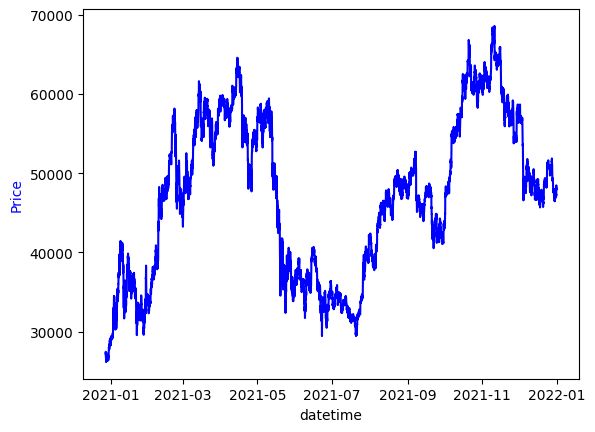

In [4]:
fig, ax1 = plt.subplots()
ax1.plot(data.index, data.close, 'b-')
ax1.set_xlabel('datetime')
ax1.set_ylabel('Price', color='b')
plt.show()

In [5]:
cyc = {
    "close": 0,
    "volume": 0
}
PCY = []
VOC = []
for idx in range(lookback_window, data.shape[0]):
    data_lb = data.iloc[idx-lookback_window+1:idx+1]
    closes = data_lb["close"].to_numpy(dtype=float)
    volumes = data_lb["volume"].to_numpy(dtype=float)
    cyc["close"] = CYC(
        data=closes,
        cyc=cyc["close"],
        short_ma_length=30,
        long_ma_length=80,
        alpha=0.33,
        lookback_window=10,
    )
    PCY.append(cyc["close"])
    cyc["volume"] = CYC(
        data=volumes,
        cyc=cyc["volume"],
        short_ma_length=30,
        long_ma_length=80,
        alpha=0.33,
        lookback_window=10,
    )
    VOC.append(cyc["volume"])

In [6]:
data_bt = data.iloc[lookback_window:].copy()
data_bt["VOC"] = VOC
data_bt["PCY"] = PCY

## Correlation

Check Pearson correlation between PCY and prices

In [7]:
def turning_points(x):
    if x[0] > x[1] and x[2] > x[1]:
        return 1
    elif x[0] < x[1] and x[2] < x[1]:
        return -1
    return 0

data_bt["PCY_interval"] = rolling_apply(
    turning_points,
    3,
    data_bt.PCY.values
)
data_bt_pcy_intervals = data_bt[
    (data_bt.PCY_interval == 1) | (data_bt.PCY_interval == -1)
]
corr_pcy = np.corrcoef(
    data_bt_pcy_intervals.close.diff().apply(lambda x: int(x>0)),
    data_bt_pcy_intervals.PCY.diff().apply(lambda x: int(x>0))
)


def turning_points(x):
    # VOC trough represents a strong trend, return 1
    if x[0] > x[1] and x[2] > x[1]:
        return 1
    # VOC peak represents trend doesn't continue, return 0
    elif x[0] < x[1] and x[2] < x[1]:
        return 0
    return None

data_bt["VOC_interval"] = rolling_apply(
    turning_points,
    3,
    data_bt.VOC.values
)
data_bt = data_bt[
    (data_bt.VOC_interval == 1) | (data_bt.VOC_interval == 0)
]

def voc_price_corr(close, voc_interval, voc):
    # VOC peak, the trend should not continue
    if voc_interval[0]==1. and voc_interval[1]==0. and voc_interval[2]==1.:
        a = voc[1] - voc[0]
        b = -abs((close[2] - close[1]) / close[1])
        return a, b
    # VOC trough, there could be a strong trend
    elif voc_interval[0]==0. and voc_interval[1]==1. and voc_interval[2]==0.:
        a = -(voc[1] - voc[0])
        b = abs((close[2] - close[1])/close[1])
        return a, b
    else:
        raise ValueError("Adjacent VOC interval should not be identical.")

voc_price = rolling_apply(
    voc_price_corr,
    3,
    data_bt.close.values,
    data_bt.VOC_interval.values,
    data_bt.VOC
)
data_bt["corr_VOC"] = voc_price[:, 0]
data_bt["corr_close"] = voc_price[:, 1]
s1 = data_bt.corr_VOC.dropna()
s2 = data_bt.corr_close.dropna()

corr_voc = np.corrcoef(s1, s2)

In [8]:
print(
    f"VOC range: [{data_bt['VOC'].min()}, {data_bt['VOC'].max()}]\n"
    f"Correlation(VOC, price): {corr_voc[0][1]}\n"
    f"PCY range: [{data_bt['PCY'].min()}, {data_bt['PCY'].max()}]\n"
    f"Correlation(PCY, price): {corr_pcy[0][1]}\n"
)

VOC range: [0.10414743438988344, 99.97937137320916]
Correlation(VOC, price): 0.009213998991683589
PCY range: [4.893227429444143e-11, 99.99999999969336]
Correlation(PCY, price): 0.09890846558533377



buy & sell signals

In [9]:
# data_bt["entry_long1"] = rolling_apply(
#     lambda VOC: int(VOC[0]>VOC[1] and VOC[2]>VOC[1]),
#     3,
#     data_bt.VOC.values
# )
# data_bt["entry_long2"] = rolling_apply(
#     lambda VOC, PCY: int(VOC[0]>VOC[1] and VOC[2]>VOC[1] and PCY[2]>PCY[1]),
#     3,
#     data_bt.VOC.values, data_bt.PCY.values
# )

# VOC bottom, PCY bottom
pcy_entry_long_threshold = 30
voc_entry_long_threshold = 10
data_bt["entry_long"] = rolling_apply(
    lambda VOC, PCY: int(
        VOC[0] > VOC[1]
        and VOC[2] > VOC[1]
        and VOC[1] < voc_entry_long_threshold
        and PCY[2] > PCY[1]
        and PCY[2] < pcy_entry_long_threshold
    ),
    3,
    data_bt.VOC.values, data_bt.PCY.values
)
# VOC bottom, PCY top
pcy_entry_short_threshold = 70
voc_entry_short_threshold = 10
data_bt["entry_short"] = rolling_apply(
    lambda VOC, PCY: int(
        VOC[0] > VOC[1]
        and VOC[2] > VOC[1]
        and VOC[1] < voc_entry_short_threshold
        and PCY[2] < PCY[1]
        and PCY[2] > pcy_entry_short_threshold
    ),
    3,
    data_bt.VOC.values, data_bt.PCY.values
)
# PCY top, VOC top
pcy_exit_long_threshold = 99
voc_exit_long_threshold = 80
data_bt["exit_long"] = rolling_apply(
    lambda VOC, PCY: int(
        PCY[0] < PCY[1]
        and PCY[1] > PCY[2]
        and PCY[1] > pcy_exit_long_threshold
        # and VOC[2] < VOC[1]
        and VOC[2] > voc_exit_long_threshold
    ),
    3,
    data_bt.VOC.values, data_bt.PCY.values
)
# PCY bottom, VOC top
pcy_exit_short_threshold = 1
voc_exit_short_threshold = 80
data_bt["exit_short"] = rolling_apply(
    lambda VOC, PCY: int(
        PCY[0] > PCY[1]
        and PCY[1] < PCY[2]
        and PCY[1] < pcy_exit_short_threshold
        # and VOC[2] > VOC[1]
        and VOC[2] > voc_exit_short_threshold
    ),
    3,
    data_bt.VOC.values, data_bt.PCY.values
)

In [10]:
data_bt_plot = data_bt[
    (data_bt.index > datetime(2021, 8, 1))
    & (data_bt.index < datetime(2021, 8, 7))
]
data_bt_plot_entry_long = data_bt_plot[data_bt_plot.entry_long==1]
data_bt_plot_exit_long = data_bt_plot[data_bt_plot.exit_long==1]
data_bt_plot_entry_short = data_bt_plot[data_bt_plot.entry_short==1]
data_bt_plot_exit_short = data_bt_plot[data_bt_plot.exit_short==1]

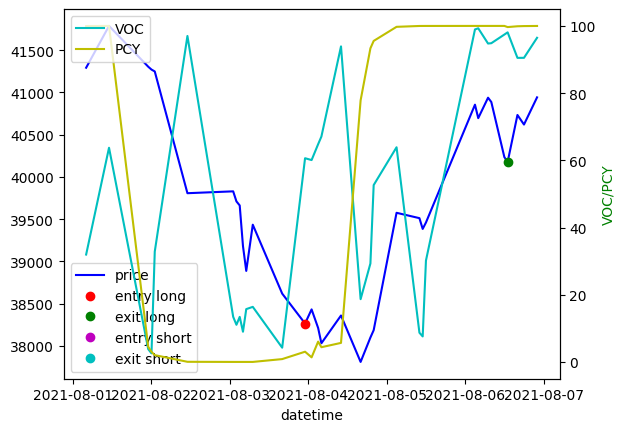

In [11]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(data_bt_plot.index, data_bt_plot.close, 'b-', label='price')
ax1.plot(data_bt_plot_entry_long.index,
         data_bt_plot_entry_long.close, 'ro', label='entry long')
ax1.plot(data_bt_plot_exit_long.index,
         data_bt_plot_exit_long.close, 'go', label='exit long')
ax1.plot(data_bt_plot_entry_short.index,
         data_bt_plot_entry_short.close, 'mo', label='entry short')
ax1.plot(data_bt_plot_exit_short.index,
         data_bt_plot_exit_short.close, 'co', label='exit short')
ax2.plot(data_bt_plot.index, data_bt_plot.VOC, 'c-', label='VOC')
ax2.plot(data_bt_plot.index, data_bt_plot.PCY, 'y-', label='PCY')
ax1.legend(loc=0)
ax2.legend(loc=2)
ax1.set_xlabel('datetime')
ax2.set_ylabel('Price', color='b')
ax2.set_ylabel('VOC/PCY', color='g')

plt.show()


Long only

In [12]:
entry_long_signal = "entry_long"
exit_long_signal = "exit_long"
stop_loss = 0.03
pos = 0
open_time_lst = []
cost_lst = []
trades = []
stop_trades = []
pnls = []
for i in range(len(data_bt)):
    row = data_bt.iloc[i]
    dt = row.index
    pnl = 0
    if row[entry_long_signal] == 1:
        pos += 1
        cost_lst.append(row.close)
        open_time_lst.append(dt)
    elif pos > 0:
        # stop loss
        close_long = []
        for idx, cost in enumerate(cost_lst):
            if (row.close-cost)/cost < -stop_loss:
                close_long.append(idx)
                pos -= 1
                open_time = open_time_lst[idx]
                close_time = dt
                prev_row = data_bt.iloc[i-1]
                pnl += (row.close - prev_row.close) / cost
                cum_pnl = (row.close - cost) / cost
                trades.append([
                    open_time,
                    close_time,
                    cum_pnl
                ])
                stop_trades.append([
                    open_time,
                    close_time,
                    cum_pnl
                ])
            else:
                prev_row = data_bt.iloc[i-1]
                pnl += (row.close - prev_row.close) / cost
        cost_lst = [cost_lst[i] for i in range(len(cost_lst))
                    if i not in close_long]
        open_time_lst = [open_time_lst[i] for i in range(len(open_time_lst))
                    if i not in close_long]
        # if exit long signal
        if pos > 0 and row[exit_long_signal] == 1:
            idx = cost_lst.index(min(cost_lst))
            cost = cost_lst.pop(idx)
            open_time = open_time_lst.pop(idx)
            close_time = dt
            pos -= 1
            cum_pnl = (row.close - cost) / cost
            trades.append([
                open_time,
                close_time,
                cum_pnl
            ])
    pnls.append(pnl)
data_bt["equity"] = np.cumsum(pnls)

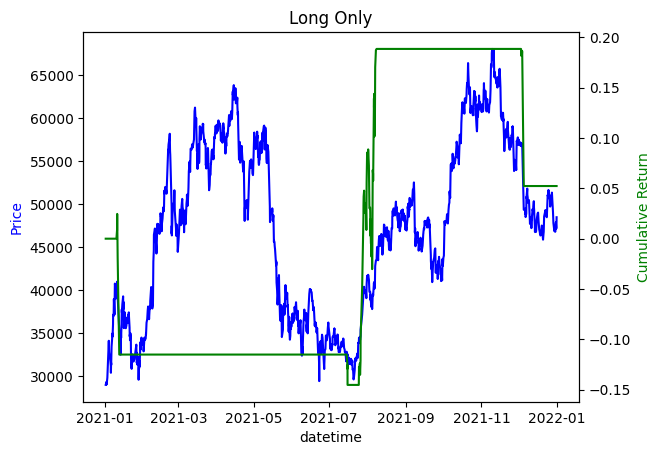

In [13]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(data_bt.index, data_bt.close, 'b-')
ax2.plot(data_bt.index, data_bt.equity, 'g-')
ax1.set_xlabel('datetime')
ax1.set_ylabel('Price', color='b')
ax2.set_ylabel('Cumulative Return', color='g')
plt.title("Long Only")
plt.show()

In [14]:
num_trades = len(trades)
num_stop_trades = len(stop_trades)
trades_pnl = [t[-1] for t in trades]
win_trades_pnl = [t[-1] for t in trades if t[-1]>0]
num_win_trades = len(win_trades_pnl)
lose_trades_pnl = [t[-1] for t in trades if t[-1]<=0]
num_lose_trades = len(lose_trades_pnl)
stop_trades_pnl = [t[-1] for t in stop_trades]
df_daily = data_bt.resample('D').agg(
    {"equity": "last"}).dropna()
sr = sharpe_ratio(
    returns=df_daily["equity"].diff().dropna(),
    days=252
)

In [15]:
print(
    "________ <Long Only> ________\n"
    f"number of trades: {num_trades}\n"
    f"number of stop trades: {num_stop_trades}\n"
    f"number of win trades: {num_win_trades}\n"
    f"number of lose trades: {num_lose_trades}\n"
    f"win trade ratio: {num_win_trades/num_trades}\n"
    f"maximum win trade: {max(trades_pnl)}\n"
    f"maximum lose trade: {min(trades_pnl)}\n"
    f"Sharpe ratio: {sr}\n"
)

________ <Long Only> ________
number of trades: 5
number of stop trades: 3
number of win trades: 2
number of lose trades: 3
win trade ratio: 0.4
maximum win trade: 0.18642397135483105
maximum lose trade: -0.13621960399852945
Sharpe ratio: 0.18093999549091958



Long Short

In [16]:
entry_long_signal = "entry_long"
exit_long_signal = "exit_long"
entry_short_signal = "entry_short"
exit_short_signal = "exit_short"
long_stop_loss = 0.03
short_stop_loss = 0.03
pos = 0
open_time_lst = []
cost_lst = []
trades = []
stop_trades = []
pnls = []
for i in range(len(data_bt)):
    row = data_bt.iloc[i]
    dt = row.index
    pnl = 0
    if row[entry_long_signal] == 1:
        # close short
        if pos < 0:
            for idx, cost in enumerate(cost_lst):
                pos += 1
                close_time = dt
                open_time = open_time_lst[idx]
                prev_row = data_bt.iloc[i-1]
                pnl += -(row.close - prev_row.close) / cost
                cum_pnl = -(row.close - cost) / cost
                trades.append([
                    open_time,
                    close_time,
                    cum_pnl
                ])
            assert pos == 0, "position incorrect"
            cost_lst = []
            open_time_lst = []
        # open long
        pos += 1
        cost_lst.append(row.close)
        open_time_lst.append(dt)
    elif row[entry_short_signal] == 1:
        # close long
        if pos > 0:
            for idx, cost in enumerate(cost_lst):
                pos -= 1
                close_time = dt
                open_time = open_time_lst[idx]
                prev_row = data_bt.iloc[i-1]
                pnl += (row.close - prev_row.close) / cost
                cum_pnl = (row.close - cost) / cost
                trades.append([
                    open_time,
                    close_time,
                    cum_pnl
                ])
            assert pos == 0, "position incorrect"
            cost_lst = []
            open_time_lst = []
        # open short
        pos -= 1
        cost_lst.append(row.close)
        open_time_lst.append(dt)
    elif pos > 0:
        # stop loss
        close_long = []
        for idx, cost in enumerate(cost_lst):
            if (row.close-cost)/cost < -long_stop_loss:
                close_long.append(idx)
                pos -= 1
                open_time = open_time_lst[idx]
                close_time = dt
                prev_row = data_bt.iloc[i-1]
                pnl += (row.close - prev_row.close) / cost
                cum_pnl = (row.close - cost) / cost
                trades.append([
                    open_time,
                    close_time,
                    cum_pnl
                ])
                stop_trades.append([
                    open_time,
                    close_time,
                    cum_pnl
                ])
            else:
                prev_row = data_bt.iloc[i-1]
                pnl += (row.close - prev_row.close) / cost
        cost_lst = [cost_lst[i] for i in range(len(cost_lst))
                    if i not in close_long]
        open_time_lst = [open_time_lst[i] for i in range(len(open_time_lst))
                    if i not in close_long]
        # if exit long signal
        if pos > 0 and row[exit_long_signal] == 1:
            idx = cost_lst.index(min(cost_lst))
            cost = cost_lst.pop(idx)
            open_time = open_time_lst.pop(idx)
            close_time = dt
            pos -= 1
            cum_pnl = (row.close - cost) / cost
            trades.append([
                open_time,
                close_time,
                cum_pnl
            ])
    elif pos < 0:
        # stop loss
        close_short = []
        for idx, cost in enumerate(cost_lst):
            if -(row.close-cost)/cost < -short_stop_loss:
                close_short.append(idx)
                pos += 1
                open_time = open_time_lst[idx]
                close_time = dt
                prev_row = data_bt.iloc[i-1]
                pnl += -(row.close - prev_row.close) / cost
                cum_pnl = -(row.close - cost) / cost
                trades.append([
                    open_time,
                    close_time,
                    cum_pnl
                ])
                stop_trades.append([
                    open_time,
                    close_time,
                    cum_pnl
                ])
            else:
                prev_row = data_bt.iloc[i-1]
                pnl += -(row.close - prev_row.close) / cost
        cost_lst = [cost_lst[i] for i in range(len(cost_lst))
                    if i not in close_short]
        open_time_lst = [open_time_lst[i] for i in range(len(open_time_lst))
                    if i not in close_short]
        # if exit short signal
        if pos < 0 and row[exit_short_signal] == 1:
            idx = cost_lst.index(max(cost_lst))
            cost = cost_lst.pop(idx)
            open_time = open_time_lst.pop(idx)
            close_time = dt
            pos += 1
            cum_pnl = -(row.close - cost) / cost
            trades.append([
                open_time,
                close_time,
                cum_pnl
            ])
    pnls.append(pnl)
data_bt["equity"] = np.cumsum(pnls)

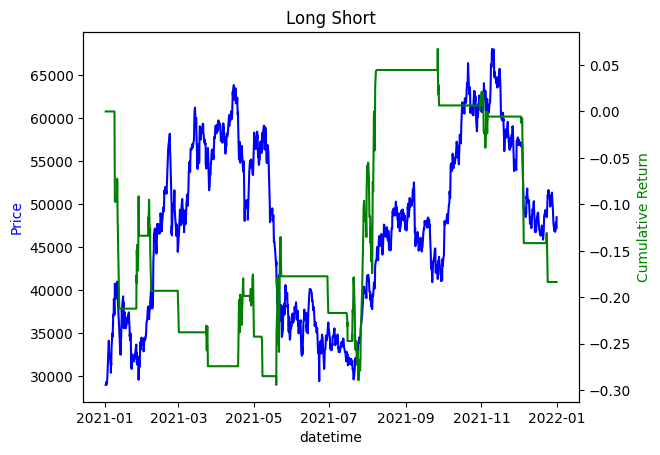

In [17]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(data_bt.index, data_bt.close, 'b-')
ax2.plot(data_bt.index, data_bt.equity, 'g-')
ax1.set_xlabel('datetime')
ax1.set_ylabel('Price', color='b')
ax2.set_ylabel('Cumulative Return', color='g')
plt.title("Long Short")
plt.show()

In [18]:
num_trades = len(trades)
num_stop_trades = len(stop_trades)
trades_pnl = [t[-1] for t in trades]
win_trades_pnl = [t[-1] for t in trades if t[-1]>0]
num_win_trades = len(win_trades_pnl)
lose_trades_pnl = [t[-1] for t in trades if t[-1]<=0]
num_lose_trades = len(lose_trades_pnl)
stop_trades_pnl = [t[-1] for t in stop_trades]
df_daily = data_bt.resample('D').agg(
    {"equity": "last"}).dropna()
sr = sharpe_ratio(
    returns=df_daily["equity"].diff().dropna(),
    days=252
)

In [19]:
print(
    "________ <Long Short> ________\n"
    f"number of trades: {num_trades}\n"
    f"number of stop trades: {num_stop_trades}\n"
    f"number of win trades: {num_win_trades}\n"
    f"number of lose trades: {num_lose_trades}\n"
    f"win trade ratio: {num_win_trades/num_trades}\n"
    f"maximum win trade: {max(trades_pnl)}\n"
    f"maximum lose trade: {min(trades_pnl)}\n"
    f"Sharpe ratio: {sr}\n"
)


________ <Long Short> ________
number of trades: 20
number of stop trades: 14
number of win trades: 6
number of lose trades: 14
win trade ratio: 0.3
maximum win trade: 0.18642397135483105
maximum lose trade: -0.13621960399852945
Sharpe ratio: -0.4618569865978983

